##### Neuromorphic engineering I

## Photoreceptors; Photoreceptor Circuits

 Created Oct 2020-Dec 2020 by Tobi Delbruck & Rui Graca

#### Group number: ...

#### Team members

 - First name: Quillan Last name: Favey
 - First name: ... Last name: ...

#### TA: ...

**Objectives of this lab**

You will compare the 2 circuits sketched below.
The left one is the _source-follower_ (**SF**) photoreceptor
and the right one is the unity-gain active _transimpendance_ feedback (**TI**) photoreceptor.

<img src='figs/lab9_photoreceptor1.png' width=800>

![photoreceptor circuits](attachment:figs/lab9_photoreceptor1.png "photoreceptor circuits")

### Exercise type and dates
COVID made it too difficult to set up a remote arrangement for testing the classchip photoreceptor circuits.
Instead, we will do some circuit analysis and numerical evaluation to
understand the concepts of feedback, loop gain, and transimpedence speedup.

The exercise spans 2 weeks with 2h per week.
There will be two groups Thursday afternoon and Monday morning.

Excercise dates: Monday group: Nov 30, Dec 7, Thursday group: Dec 2, Dec 9,
Monday group: Dec 6 and Dec 13.

Due date: Dec 20 2021

### Running the notebook

You will run this exercise on your own computer using any available Jupyter server. If you have one
already, you can use it. But you don't need to:
https://www.dataschool.io/cloud-services-for-jupyter-notebook/
provides a list of free servers on the cloud that you can use after registration.

### Requirements: libraries needed
 python 3.7+

You might need to install libraries. You can install them from terminal into your python enviroment with
``` bash
pip install jupyter matplotlib numpy  scipy engineering_notation engineering_notation
```
Remember, when using any python, conda is your friend. Make a unique conda enviroment
 for each project to save yourself a lot of trouble with conflicting libraries. Here we will use only
 very standard libraries that are provided by all the Jupyter servers.


In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math
from scipy.integrate import solve_ivp #  - for timestepping ODEs
import os
from engineering_notation import EngNumber as eng # useful library to e.g. format eng(1e-3) as 1m
from scipy.stats import linregress

### ------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

### Define useful constants

In [3]:
I_0= 1e-14 # FET off current - you measured it TODO check correct for classchip process
U_T= 25e-3# you better know this
kappa=.8 # choose a reasonable value
vdd=1.8 # power supply voltage
q=1.6e-19 # charge of electron

V_e=10 # Early voltage for the TI photoreceptor amplifier input FET that we will use later. 1V is very small and would be less than what you would get from minimum length FET

### Define useful functions
Let's define a function for subthreshold current that
includes optional Early voltage for finite drain
conductance:

In [4]:
def id_sub(V_g, V_s=0, V_d=1.8, U_T=U_T, I_0=I_0, kappa=kappa, V_e=V_e):
    """ Computes the drain current from gate, source and drain voltage.
    At most one of V_g, V_s, V_d can be a vector in which case I_d is a vector

    :param V_g: gate voltage
    :param V_s: source voltage, by default 0
    :param V_d: drain voltage, by default 1V
    :param: U_T: thermal voltage
    :param I_0: the off current
    :param V_e: the Early voltage; drain conductance is Idsat/V_e

    :returns: the drain current in amps
    """
    Vds=V_d-V_s
    Id_sat=I_0*np.exp(((kappa*V_g)-V_s)/U_T)
    I_d=Id_sat*(1-np.exp(-Vds/U_T))
    if V_e!=np.infty:
        I_d=I_d*(1+Vds/V_e)
    return I_d

Check that the subthreshold equation makes sense. Start by plotting the drain current versus gate voltage, and
check that the slope is 1 e-fold per U_T/kappa.

Transconductance: Measured efold current gate voltage=31.25mV, predicted from U_T/kappa=31.25mV
Transconductance OK


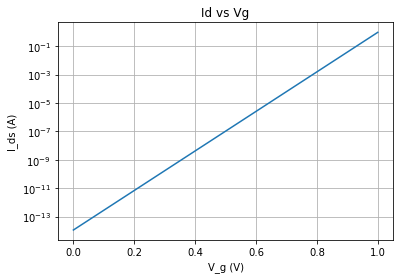

In [5]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math
vg=np.linspace(0,1,100)
# drain current vs gate voltage (transconductance)
idvsvg=id_sub(vg)

plt.figure('idsat')
plt.semilogy(vg,idvsvg)
plt.xlabel('V_g (V)')
plt.ylabel('I_ds (A)')
plt.title('Id vs Vg')
plt.grid(True)

reg=linregress(np.log(idvsvg), vg )
efold_v_meas=reg[0]
efold_v_theory=U_T/kappa
print(f'Transconductance: Measured efold current gate voltage={eng(efold_v_meas)}V, predicted from U_T/kappa={eng(efold_v_theory)}V')
if np.abs((efold_v_meas-efold_v_theory)/(.5*(efold_v_meas+efold_v_theory)))>.01:
    raise ValueError('Something wrong with subthreshold equations')
else:
    print('Transconductance OK')

Now plot the drain current vs drain voltage and check that the actual drain conductance matches the expected value.

Output conductance: Measured g_out=9.04n, predicted from g_out=Id_sat/Ve=8.89n
Drain conductance OK within 5%


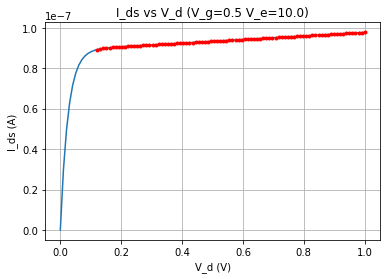

In [6]:
vd=np.linspace(0,1,100)
V_g=.5
idsat=I_0*np.exp(kappa*V_g/U_T)
# drain current vs drain voltage (drain conductance)
idvsvd=id_sub(V_g=V_g, V_d=vd, V_e=V_e)

plt.figure('idsat2')
plt.plot(vd,idvsvd)
plt.xlabel('V_d (V)')
plt.ylabel('I_ds (A)')
plt.grid(True)
plt.title('I_ds vs V_d (V_g={:.1f} V_e={:.1f})'.format(V_g,V_e))

r=[i for i in range(len(idvsvd)) if idvsvd[i] >= idsat]

plt.plot(vd[r],idvsvd[r],'.r')
reg=linregress(vd[r], idvsvd[r] )
gout_meas= reg[0]
gout_pred=I_0*np.exp(kappa*V_g/U_T)/V_e
print(f'Output conductance: Measured g_out={eng(gout_meas)}, predicted from g_out=Id_sat/Ve={eng(gout_pred)}')
if np.abs((gout_meas-gout_pred)/(.5*(gout_meas+gout_pred)))>.05:
    raise ValueError('Something wrong with subthreshold equations')
else:
    print('Drain conductance OK within 5%')

It seems to make sense. Now we have an equation we can use in ODE equation for photoreceptors

### Estimating actual photocurrent

Now we need to compute reasonable values for photocurrent and dark current.
Let's take the interesting situation of operation in dark
conditions at 1 lux scene illumination, which is about 10 times moonlight.
The light falling onto the chip will be reduced by the optics
according to the equation below.

We will also assume a photodiode area of 10um^2
which is a reasonably-large photodiode, and we will
assume a not-so-great junction leakage "dark current" of 1nA/cm^2.

$$
I_{chip} = \frac{I_{scene}R \times QE}{4f^2}
$$

where $I$ is illuminance in $lux$, $f$ is focal length aperture, $QE = 0.5$ is quantem efficiency, $R$ is the scene reflectance

In [7]:
scene_flux_lux = 10  # 1 lux is about ten times moonlight
photodiode_area_um2 = 10  # photodiode area m^2
# optics reduces light intensity by square of aperture ratio
# we will assume a cheap f/3 lens with ratio focal length to aperture of 3


def optics_reduction(flux):
    f_number = 3
    return flux/(4*f_number*f_number)


avg_reflectance = .18  # kodak's estimate of average scene reflectance
chip_flux_lux = optics_reduction(scene_flux_lux)

# you get about this many photons per lux falling on chip with "visible" sunlight spectrum
photons_per_um2_per_lux = 1e4
photocurrent_e_per_sec = chip_flux_lux * (photons_per_um2_per_lux) * photodiode_area_um2
    
dark_current_amps_per_um2 = (1e-9/1e-4)*1e-12  # junction leakage per m^2
dark_current_amps = photodiode_area_um2*dark_current_amps_per_um2
dark_current_e_per_sec = dark_current_amps/q
photocurrent_amps = photocurrent_e_per_sec*q
photocurrent_total_amps = photocurrent_amps+dark_current_amps

print(f'scene illumination level {eng(scene_flux_lux)}lux\n'
      f'photodiode area: {photodiode_area_um2}um^2\n'
      f'DC photocurrent: {eng(photocurrent_total_amps)}A\n'
      f'dark current: {eng(dark_current_e_per_sec)}e/s or {eng(dark_current_amps)}A\n'
      f'I_0 off current: {eng(I_0/q)}e/s or {eng(I_0)}A\n')


scene illumination level 10lux
photodiode area: 10um^2
DC photocurrent: 4.54fA
dark current: 625e/s or 100aA
I_0 off current: 62.50ke/s or 10fA



Is the value smaller than the off-current?  Yes 
This is not surprising; under dark conditions, the photocurrent can be
a small fraction of the FET off-current.

#### Making a photocurrent stimulus waveform
Now we will make a waveform input stimulus to drive our time-domain simulations of the photoreceptors.
 Let's define our input photocurrent waveform we will use
it is a square wave with modulation of contrast signal_contrast and starts with bright DC level and then goes
 to dark DC level

source follower photodiode capacitance C_pd=100fF and tau_sf=5.63s
Computed period: 11.25s


Text(0, 0.5, 'I_pd [A]')

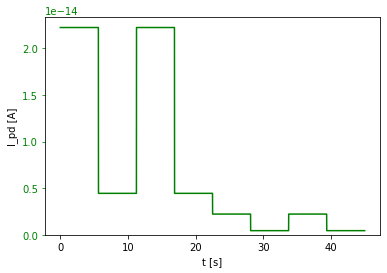

In [31]:

import numpy as np
from scipy.signal import square
import matplotlib.pyplot as plt # plotting

dark=dark_current_amps # dark current level
sigdc1=photocurrent_amps # DC photocurrent for bright half
sigdc2=photocurrent_amps/10 # and dark half
signal_contrast=5 # contrast in each half, i.e. cont=10 means that the bright part will be 10 times the dark half period, 2 means 2 times
nper=2 # how many periods to simulate for each half bright/dark
# to compute the period, let's make it so that half a period is 1 time constants for SF in dark part of scene
C_pd=100e-15 # guesstimate about 100fF
tau_sf=C_pd*U_T/sigdc2
per=2*tau_sf # period in seconds

print(f'source follower photodiode capacitance C_pd={eng(C_pd)}F and tau_sf={eng(tau_sf)}s\n'
      f'Computed period: {eng(per)}s')
dt=per/50000 # timesteps per half period
time_basis=np.arange(0,2*nper*per,dt) # start,stop,step generate time basis that is nper long
npts=len(time_basis)
npts2=int(npts/2)
# generate square wave with period per using time basis t that has steps dt
# square(x) has period 2*pi, i.e. its output is 1 when input is 0-pi, then -1 for pi-2pi, then 1 again
# thus if we want to have nper cycles in each half of our stimulus, we need to
# make its argument go to 2pi when the time goes to per
# Also, shift it up and divide by 2 to get 0-1 modulated square
sq=(square((2*np.pi*time_basis)/(per))+1)/2
# convolve with a short box filter to
# make the edges not perfectly square to simulate finite optical aperture
# sq=np.convolve(sq,np.ones(10)/10,mode='same') # causes some wierd transient, didn't debug

sig=np.zeros_like(sq)
sig[:npts2]=sigdc1*(1+(signal_contrast-1)*sq[:npts2])
sig[npts2+1:]=sigdc2*(1+(signal_contrast-1)*sq[npts2+1:])
sig[npts2]=sigdc2*(1+(signal_contrast-1)*sq[npts2+1])
photocurrent_waveform=sig
# plt.plot(t,cur)

fig,ax1=plt.subplots(sharex=True)
ax1.plot(time_basis,photocurrent_waveform,'g',)
ax1.set_ylim([0,None])
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('I_pd [A]')

Contrast ratio remains the same

We need to make a function out of our nice I_pd vector so that we can get I_pd at any point in time

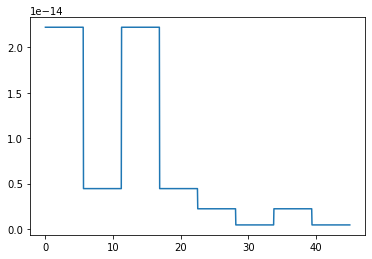

In [32]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="right")
    return idx
def I_pd_function(time,time_basis,photocurrent_waveform):
    idx=find_nearest_idx(time_basis,time)
    idx-=1 # go to next point just to left since search finds point just before time
    if idx<0: return photocurrent_waveform[0]
    if idx>=(len(time_basis)-1): return photocurrent_waveform[-1]
    t1=time_basis[idx]
    i1=photocurrent_waveform[idx]
    idx+=1
    t2=time_basis[idx]
    i2=photocurrent_waveform[idx]
    tfrac=(time-t1)/(t2-t1) if t2-t1>0 else .5
    i=(1-tfrac)*i1+tfrac*i2
    return i
I_pd = lambda t: I_pd_function(t,time_basis,photocurrent_waveform)
# test it
ttest=np.linspace(0,time_basis[-1],1000)
itest=[]
for t in ttest: itest.append(I_pd(t))
itest=np.array(itest)
plt.plot(ttest,itest)





### Exercise 1: Static vs. active unity-gain photoreceptors DC responses

First you will plot the theoretical DC responses of SF and TI to input photocurrent.

We will compute expressions for the DC response of the simple and unity gain feedback photoreceptor circuits.

We compute the SF output for you.

In [33]:

i_pd=np.logspace(-19,-6,100) # input photocurrent vector, log scale from well under I_0 and dark current to microamp, which is huge


# equation for SF DC output, assuming gate voltage of 1.4V
v_g=1.4
v_sf= kappa*v_g-U_T*np.log((i_pd+dark_current_amps)/I_0)


**(a)** Computing the TI photoreceptor DC output

==check formulas==

Let's define a function for the TI photoreceptor DC output. We can use that to plot it, and later on use
it to define the initial condition for the TI photoreceptor voltage at the start of transient simulation.

Assume for the TI circuit that the gain of the feedback amplifier is infinite and that the amplifier is ideal, i.e. that
the input FET never goes out of saturation.

You should fill in the expressions for the TI photodiode and output voltages:

In [34]:
def ti_dc(I_b,I_pd,I_0=I_0,V_e=V_e,U_T=U_T,kappa=kappa,I_dark=dark_current_amps):
    """ Computes the theoretical DC operating point of TI photoreceptor given parameters
    :param I_b: bias current, should be scalar
    :param I_pd: photocurrent, can be vector
    :param V_e: amplfifier input FET Early voltage
    :param U_T: thermal voltage
    :param kappa: back gate coefficient of all FETs

    :returns: [V_pd, V_out] voltages in form suitable for solve_ivp initial condition
    """
    # TODO include effect of finite amplifier gain, not accounted for now
    # check that I_b is scalar
    if not np.isscalar(I_b):
        raise ValueError('I_b should be a scalar')
    # TODO compute the photodiode voltage.  It is determined by Ib, right?
    V_pd= (U_T/kappa) * np.log(I_b/I_0) #assuming V_b = 1.4 mV      <-------
    # we need to handle that I_pd might be scalar or vector
    if not np.isscalar(I_pd):
        V_pd=np.ones(len(I_pd))*V_pd
    # TODO compute the TI output voltage expression
    V_out= (V_pd + U_T * np.log(I_pd/I_0))/kappa #assuming V_b = 1.88 mV <-------
    return [V_pd, V_out]

# check DC output
I_b=10e-9 # biais current for amplifier pullup Mp in TI photoreceptor
ip=I_pd(0)
vti0=ti_dc(I_b,photocurrent_amps)
print(f'DC output of TI with bias current I_b={eng(I_b)} '
      f'and photocurrent I_p={eng(photocurrent_amps)} '
      f'are vpd={eng(vti0[0])}V vout={eng(vti0[1])}V')


DC output of TI with bias current I_b=10n and photocurrent I_p=4.44f are vpd=359.78mV vout=352.43mV


**(b)** Plot the SF and TI DC output together on a log-linear plot of $V_{out}$ versus
$I_{pd}$, covering a range of photocurrents of $I_{pd}$ from 0.01fA to 10nA. Assume $I_0$=1e-13A and that
there is dark current of $I_{dark}$=0.1fA.

Text(0, 0.5, 'Output voltage (V)')

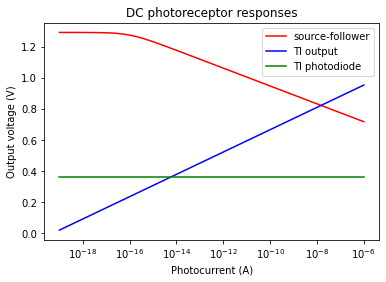

In [35]:
# compute the vector of TI outputs. The function returns a list of 2 vectors, [V_pd,V_out]
I_0= 1e-13

v_ti=ti_dc(I_b, i_pd,I_dark=1e-16)

plt.figure('DC responses')
plt.title('DC photoreceptor responses')
#plt.semilogx(i_pd,v_sf,'b-')
plt.semilogx(i_pd,v_sf,'r-', i_pd,v_ti[1],'b-', i_pd,v_ti[0],'g-') # TODO uncomment line to plot v_ti
plt.legend(['source-follower','TI output','TI photodiode'])
plt.xlabel('Photocurrent (A)')
plt.ylabel('Output voltage (V)')

### Preparation for large signal transient (time-domain) simulations


It seems to make sense. Now we have equations we can use in ODE equation for photoreceptors



### Dynamical equations

Next we will write the dynamical equations for the source-follower and feedback photoreceptor using the id_sub equation
for the currents. We need to write the right hand side equation for
```
dy / dt = f(t, y)
```
given initial condition
```
y(t0) = y0
```
The source follower only has one node so the output is a scalar derivative.
The TI photoreceptor has 2 nodes (the photodiode and output), so the output is a vector of 2 deriatives w.r.t. time.

For the source follower we have:

$$
c \frac{dVout}{dt} = I_0 e^{\frac{\kappa Vg- Vout}{U_T}}-I(t)
$$

For the feedback photoreceptor, we have:

$$
\begin{cases}
     & C1 \frac{dVpd}{dt} = I_0 e^{\frac{\kappa Vout-Vpd}{U_T}}-I(t)\\
     & C2 \frac{dVout}{dt} = I_b-I_0 e^{\frac{\kappa Vpd}{U_T}}-\frac{Ib}{V_e}V_{out}\\
\end{cases}  
$$

### Exercise 2: Large signal transient response of source follower and active photoreceptors

As an example, below we define the RHS for the SF. The time derivative of the output voltage is the current
divided by the node capacitance:

In [36]:
def sfdvdt(t,y,V_g=1.4,C_pd=100e-15): # fill in reasonable photodiode capacitance, e.g. 100fF
    vdot=  (id_sub(V_g=V_g, V_s=y)-I_pd(t))/C_pd
    return vdot

### Exercise 2.1: define RHS of ODE for TI receptor

Now you should do the same thing, but for the vector of TI node voltages [vpd,vout] for the vpd input (photodiode)
and vout output nodes:

In [37]:
def tidvdtpd(t, y, Ib, I_pd, V_e=V_e, C_pd=100e-15, C_out=1e-15):
    """ Compute time derivatives of TI photoreceptor node voltages

    :param t: the time in s
    :param y: the TI PD and output voltages vector [vpd,vout]
    :param V_e: the amplifier input n-fet Early voltage in V
    :param C_pd: the photodiode cap in Culombs
    :param C_out: the output capacitance

    :returns: the vector of photodiode/output voltage time derivatives
    """
    vpd = y[0]
    vout = y[1]
    # you fill in next parts from equations for TI photoreceptor.

    # TODO
    vpd_dot = (id_sub(V_g=vpd, V_s=vout)-I_pd(t))/C_pd
    #vout_dot = (Ib-id_sub(V_g=vpd, V_s=0)-(I_b/V_e)*vout)/C_out
    yout = [vpd_dot]
    return yout

def tidvdtout(t, y, Ib, I_pd, V_e=V_e, C_pd=100e-15, C_out=1e-15):
    """ Compute time derivatives of TI photoreceptor node voltages

    :param t: the time in s
    :param y: the TI PD and output voltages vector [vpd,vout]
    :param V_e: the amplifier input n-fet Early voltage in V
    :param C_pd: the photodiode cap in Culombs
    :param C_out: the output capacitance

    :returns: the vector of photodiode/output voltage time derivatives
    """
    vpd = y[0]
    vout = y[1]
    # you fill in next parts from equations for TI photoreceptor.

    # TODO
    #vpd_dot = (id_sub(V_g=vpd, V_s=vout)-I_pd(t))/C_pd
    vout_dot = (Ib-id_sub(V_g=vpd)-(I_b/V_e)*vout)/C_out
    yout = [vout_dot]
    return yout

### Exercise 2.2: Timestepping transient simulation of photoreceptors

Below we have done it for the SF photoreceptor.
You should add the TI photoreceptor to the simulation so you can compare them to each other.
YOu may find issues with the simulator not responding to some of the edges in
the photocurrent. If this is the case, you can try to decrease tolerance (rtol
and atol), and also try different methods. Check solve_ivp() documentation for the
different options.

The solver successfully reached the end of the integration interval.
DC output of TI with I_b=10n and I_pd=22.22f are vpd=359.78m vout=402.72m
[0.35977892078031964, 0.402721232326141]
The solver successfully reached the end of the integration interval.
[0.0000000e+00 2.2500000e-04 4.5000000e-04 ... 4.4999325e+01 4.4999550e+01
 4.4999775e+01]


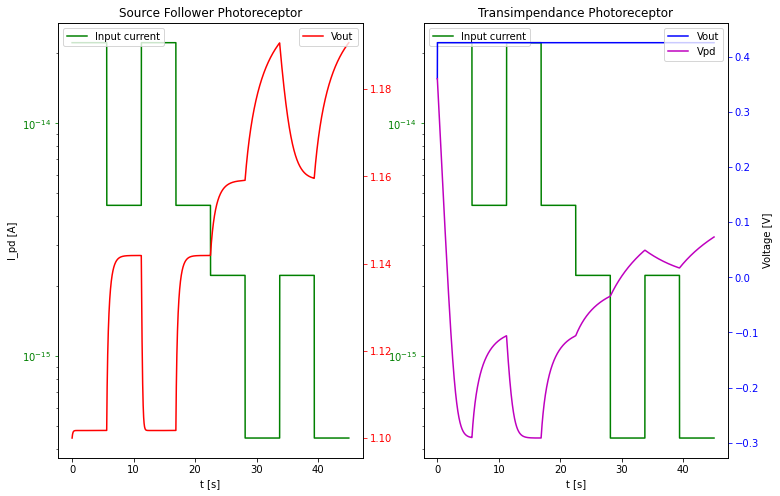

In [38]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math
from scipy.integrate import solve_ivp # for timestepping ODEs

V_sf0= [1.1]# initial condition of v, just guess it to be approx Vg-a bit, e.g. 1.4-.3
sf_sol=solve_ivp(sfdvdt, (time_basis[0],time_basis[-1]),V_sf0, t_eval=time_basis,
                 rtol=1e-10,atol=1e-20, method='LSODA',
                 #rtol=1e-9,atol=1e-20, method='Radau',
                 args=(1.4,C_pd))
# output is sol.t and sol.y
if sf_sol.message is not None:
    print(sf_sol.message)
v_sf=sf_sol.y[0]
t_sf=sf_sol.t


# TODO you can solve the TI by filling in below
# check DC output
ib=I_b
ip=I_pd(0)
V_ti0=ti_dc(I_b,ip)
print(f'DC output of TI with I_b={eng(I_b)} and I_pd={eng(ip)} are vpd={eng(V_ti0[0])} vout={eng(V_ti0[1])}')
print(V_ti0)
C_out=1e-15
ti_sol1=solve_ivp(tidvdtpd, (time_basis[0],time_basis[-1]),V_ti0, t_eval=time_basis,
                rtol=1e-8, atol=1e-21, method='Radau',
                 #rtol=1e-9, atol=1e-19, method='RK45',
                 args=(I_b,I_pd,V_e,C_pd,C_out))
ti_sol2=solve_ivp(tidvdtout, (time_basis[0],time_basis[-1]),V_ti0, t_eval=time_basis,
                rtol=1e-5, atol=1e-10, method='Radau',
                 #rtol=1e-9, atol=1e-19, method='RK45',
                 args=(I_b,I_pd,V_e,C_pd,C_out))
### output is sol.t and sol.y
if ti_sol1.message is not None:
    print(ti_sol1.message)
v_ti=ti_sol2.y[0]
t_ti=ti_sol2.t
v_pd=ti_sol1.y[0]
t_pd=ti_sol1.t

# use this plotting style to put several plots sharing same x-axis
# we will plot V_sf together with the input photocurrent
# using another axis since it is volts, not current, and linear not log
fig=plt.figure(figsize=(12,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharex = ax1)

ax1.plot(time_basis,photocurrent_waveform,'g')
ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('I_pd [A]')
ax1.title.set_text('Source Follower Photoreceptor')
ax2.title.set_text('Transimpendance Photoreceptor')

ax3=ax1.twinx()
ax3.plot(t_sf,v_sf,'r-')
ax3.tick_params(axis='y', colors='red')
ax1.legend(['Input current'], loc='upper left')
ax3.legend(['Vout'], loc='upper right')

ax2.set_yscale('log')
ax2.set_xlabel('t [s]')

ax2.tick_params(axis='y', colors='green')
ax2.set_xscale('linear')


ax2.plot(time_basis,photocurrent_waveform,'g',)
ax2.legend(['Input current'], loc='upper left')

# TODO: Uncomment for TI photoreceptor
ax4=ax2.twinx()
ax4.set_ylabel('Voltage [V]')
#ax4.set_ylim([0.4,0.8])
ax4.plot(t_ti, v_ti,'b-',t_pd,v_pd,'m-')
ax4.tick_params(axis='y', colors='blue')
ax4.legend(['Vout', 'Vpd'], loc='upper right')
print(t_ti)


Note that in above transient solution, you might get a startup glitch particularly
for the TI photoreceptor because your TI DC solution
at the starting time is not quite correct. It means that the V_pd and V_out and not consistent,
and so the circuit will go through a short period of adjustment to come to the steady-state level.

### Exercise 3: Small signal modeling

You already did the most difficult part which is the large signal modeling. Now we will fix
the operating point around some DC level and compute the small signal transfer functions.
From these we can see the cutoff frequencies and stability.

### Exercise 3.1: AC transfer functions (Bode plots) of static vs. active photorecptors

**(a)**  Write the small-signal differential equations for the simple photoreceptor and the unity-gain feedback photoreceptor assuming
photodiode capacitance $C_{pd}$ and (for the feedback photoreceptor) output load capacitance $C_{out}$.
For the feedback photoreceptor, you can assume that that amplifier has a output resistance $g_{out}$=$I_b$/$V_e$
(recall that the DC voltage gain is A=-$g_m$/$g_{out}$).

![](2022-12-05-17-12-02.png)

**Simple photoreceptor**
$$
C_{pd}\dot{V_{out}} = g_{M1}V_g-g_{pd}V_{pd}-i  
$$


**Unity gain feedback**
For the left branch of the circuit we have:
$$
g_{m1} V_{2} = g_{s1}V_1 + C_{pd} \dot{V1} + i \\
C_{pd} \dot{V1} = g_{m1} V_{2} - g_{s1}V_1 - i
$$


![](2022-12-05-17-43-35.png)

For the right branch we have (M2 is modelled by $g_{m2}V_1$):

![](2022-12-05-17-41-58.png)

![](2022-12-05-17-42-47.png)

And we then get the following system of equations:

![](2022-12-05-17-45-12.png)

**(b)** From the differential equations, derive the transfer functions $H(s)$ for each circuit.

Your equations should end up with time constants $\tau_{in}$ (for the photodiode node) and $\tau_{out}$
for the feedback photoreceptor.

For this derivation, the input to the circuit is the small-signal photocurrent $i_{pd}$ which is its deviation from
the DC value $I_{pd}$. The output is the small signal output voltage $v_{out}$.
But since the circuit is a log photoreceptor, a better way to express the transfer function
is to write it as output voltage per log input current. Thus $H(s)$ will be the transimpedance
'gain' that transduces from $i_{pd}/I_{pd}$ to $v_{out}$, i.e.
the units of H(s) are volts/(fractional change in current).

$$
H(s) = \frac{\frac{U_T}{\kappa I_{bg}}}{\frac{\tau_{in} \tau_{out} s^2}{A \kappa} + \frac{s(\tau_{in} + \tau_{out})}{A \kappa} + 1}
$$

**(c)** The TI feedback should make the TI photoreceptor
faster to respond to changes in photocurrent than the SF photoreceptor
(and also noisier).

By setting $\tau_{out}$ to zero (taking the limit as $\tau_{out}$ goes to zero), compute the expected speedup from the feedback.
I.e., what is the ratio of cutoff frequency of TI to SF circuit when $I_b$ is really large?
You will see if it true (at least in the model) in the Bode magnitude transfer function plots.


If we take the denominator of the transfer function and take the linit at $\tau_{out}$ goes to zero, we get:

$$
\lim_{\tau_{out} \to 0}D(s) = \frac{s\tau_{in} }{A \kappa} + 1
$$


If we compute the poles we get:

$$
s = -\frac{\kappa A}{\tau_{in}}
$$

**(d)**  Plot the magnitude of the transfer functions versus frequency, assuming reasonable values for $\tau_{in}$, $\tau_{out}$, etc
and an intermediate DC value of photocurrent, e.g. $I_{pd}$=1pA.  You can assume that the bias current of the amplifier
for the feedback photoreceptor is $I_b$=10nA and $V_e$=10V.

Remember that frequency in radians per second is $w$=$2 \pi f$ where $f$ is frequency in Hertz.

You can use numpy to compute the magnitude of the complex transfer function by using $s$=$jw$ where $j$ is $\sqrt{-1}$.

Assume the DC photocurrent is still photocurrent_amps from above.


In [16]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math

Ipd_dim=photocurrent_total_amps

freq = np.logspace(-2,6,100) # plot from 1kHz to 1GHz
w=2*np.pi*freq
tau_sf = C_pd*U_T/Ipd_dim # tau_sf = C_pd/gs_sf
H_sf = U_T/(np.sqrt(np.square(w*tau_sf)+1))
sf_cutoff_hz=1/(2*np.pi*tau_sf)

print(f'source follower photodiode capacitance C_pd={eng(C_pd)}F and tau_sf={eng(tau_sf)}s\n'
      f'SF cutoff frequency: {eng(sf_cutoff_hz)}Hz')

# TODO TI photoreceptor
tau_in=...
tau_out=...
A=...
H_ti=...

ti_cutoff_hz=sf_cutoff_hz*(kappa*A+1)

print(f'transimpedance TI cutoff frequency: {eng(ti_cutoff_hz)}Hz')


fig,ax1=plt.subplots(sharex=True)
#ax1.plot(freq,H_sf,'b')
ax1.plot(freq,H_sf,'b',freq,H_ti,'r')
# ax1.plot(sf_cutoff_hz,'o')
#ax1.set_ylim([0,None])
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('f [Hz]')
ax1.set_ylabel('|H(s)| [V/(A/A)]')
ax1.grid()





source follower photodiode capacitance C_pd=100fF and tau_sf=550.12ms
SF cutoff frequency: 289.31mHz


TypeError: unsupported operand type(s) for *: 'float' and 'ellipsis'

**(c)**  Comment on your results. Can you see the effect of feedback on the bandwidth in the TI circuit? Can you observe
some ringing? I.e. is the circuit overdamped or underdamped at this $I_b$ and $I_{pd}$?

### Exercise 4: Root-locus plot of TI photoreceptor

As the photocurrent increases, it should be clear that the single pole of the SF photoreceptor moves farther away
from the origin, as it speeds up.

Here you will compute the poles of the TI photoreceptor transfer function and then plot their locations
on the complex plane as a function of the amplfier bias current  $I_b$, given a fixed photocurrent $I_{pd}$.

The two poles of the quadratic demoninator $D(s)$ of $H(s)$ will either both be real or form a complex conjugate pair
(since all the coefficients of the polynominal are real).


**(a)** First let's define a function to get the poles and the Q factor given the
circuit parameters. Remember that a second order system (with no zeros) can be described by a
transfer function of the type
$H(s)=\frac{A}{\frac{1}{\omega_0^2}s^2+\frac{1}{Q\omega_0}s+1}$, where
$\omega_0$ (natural frequency) and $Q$ (quality factor) are characteristics of the system.

In [ ]:
def get_poles(Ipd,Ib,C_pd,C_out,V_e,U_T=U_T,kappa=kappa):
    # TODO:
    tau_in=...
    tau_out=...
    coef2=...
    coef1=...
    coef0=...
    Q=...

    # apply quadratic formula to find roots of the transfer function denominator
    # 0j in sqrt forces result to be complex
    pole1=(-coef1+np.sqrt(0j+coef1*coef1-4*coef0*coef2))/(2*coef2)
    pole2=(-coef1-np.sqrt(0j+coef1*coef1-4*coef0*coef2))/(2*coef2)
    return [pole1,pole2,Q]

**(b)** Now let's plot the root locus. The resulting plot is a trajectory in the
complex plane as a function of $I_b$

In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math

Ib_sweep = np.logspace(-15,-6,10000) # define range of Ib, adjust it to show the loop
Ipd_bright = 100e-12 # Photocurrent of 100pA

pole1,pole2,Q=get_poles(Ipd=Ipd_bright,Ib=Ib_sweep,C_pd=C_pd,C_out=C_out,V_e=V_e)

# plot
fig,ax1=plt.subplots(sharex=True)
ax1.plot(np.real(pole1),np.imag(pole1),'b')
ax1.plot(np.real(pole2),np.imag(pole2),'r')
ax1.set_xlabel('Real')
ax1.set_ylabel('Imag')
ax1.legend(['pole1','pole2'])


As you should be able to see in the root locus plot, for some values of
$I_b$ both poles lie in the real axis, but by decreasing $I_b$, the poles become
complex cojugates.

Let's now see the impact of pole location on the transient
behavior of the circuit.


**(c)** First, for a particular photocurrent (which of course is not true in practice, it varies tremendously),
find the minimum value of $I_b$ that results in a critically damped
circuit. In the exactly critically-damped condition, Q equals 0.5, and the transient response should
show no ringing since it consists of 2 low pass filters in series with equal time constants.
This bias current is also the minimum value of $I_b$ that results in real
valued poles at that photocurrent.

For the photocurrent, you can use the DC photocurrent under the illumination condition at the start
of the waveform, which is called Ipd_bright.

In [ ]:
# plot root locus again
fig,ax1=plt.subplots(sharex=True)
ax1.plot(np.real(pole1),np.imag(pole1),'b')
ax1.plot(np.real(pole2),np.imag(pole2),'r')
ax1.set_xlabel('Real (rad/s)')
ax1.set_ylabel('Imag (rad/s)')
ax1.legend(['pole1','pole2'])

#TODO fill expression Ib that results in a Q of 0.5
Ib_Qhalf=...
pole1_Qhalf,pole2_Qhalf,Q_Qhalf=get_poles(Ipd=Ipd_bright,Ib=Ib_Qhalf,C_pd=C_pd,C_out=C_out,V_e=V_e)
ax1.plot(np.real(pole1_Qhalf),np.imag(pole1_Qhalf),'bo')
ax1.plot(np.real(pole2_Qhalf),np.imag(pole2_Qhalf),'ro')
ax1.legend(['pole1','pole2','Q=1/2','Q=1/2'])

print(f"Q: {Q_Qhalf}")
print(f"Ib_Qhalf: {Ib_Qhalf}A")


Note that you might have made some small approximations that result in the $Q=1/2$ poles not quite
coming together on the real axis.

I.e. in the transfer function $H(s)$, maybe you dropped a constant term?

Or maybe to find the $Q=1/2$ condition, you simplified by assuming $\tau_2<<\tau_1$?

**(d)** Let's now look at the transient response of a TI photoreceptor operating
under such conditions. First let's define a small signal transient input photocurrent

In [ ]:
sigdc_ss=Ipd_bright
#sigdc=1e-15
signal_contrast_ss=1.1 # contrast in each half, i.e. cont=10 means that the bright part will be 10 times the dark half period, 2 means 2 times
tau_ss=C_pd*U_T/sigdc_ss
t_warmup=tau_ss*30
t_total=t_warmup+tau_ss*20
Ipd_warmup=Ipd_bright
Ipd_final=Ipd_bright/signal_contrast_ss

def Ipd_step_func(t,I_t0=Ipd_warmup, I_t1=Ipd_final, t_warmup=t_warmup):
    if t<t_warmup:
        return I_t0
    else:
        return I_t1

dt_ss=tau_ss/1000
time_basis_ss=np.arange(0,t_total,dt_ss) # start,stop,step generate time basis that is nper long
npts_ss=len(time_basis_ss)

# compute actual Ipd for timesteps
Ipd_ss=np.empty(npts_ss)
for t,i in zip(time_basis_ss,range(npts_ss)):
    Ipd_ss[i]=Ipd_step_func(t)
fig,ax1=plt.subplots(sharex=True)
ax1.plot(time_basis_ss,Ipd_ss,'g',)
#ax1.set_ylim([0,None])
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('I_pd [A]')


**(e)** Observe the transient response of the photoreceptor under such
conditions. Does it behave as expected? Try also other values of Q, both above
and below 0.5. Plot them in the root locus and observe the transient
response. When is the system overdamped and when is it underdamped? Observe how
the root locus trajectory changes with $I_b$.

In [ ]:
# initial condition
V_ti0=ti_dc(Ib_Qhalf,Ipd_bright,I_0=I_0,V_e=V_e,U_T=U_T,kappa=kappa)
print(f'DC output of TI with Ib={eng(Ib_Qhalf)} and Ip={eng(Ipd_bright)} are vpd={eng(V_ti0[0])} vout={eng(V_ti0[1])}')
ti_sol=solve_ivp(tidvdt, (time_basis_ss[0],time_basis_ss[-1]),
                 V_ti0, t_eval=time_basis_ss, rtol=1e-9, atol=1e-19, method='Radau',
                 args=(Ib_Qhalf,Ipd_step_func,V_e,C_pd,C_out))
# output is sol.t and sol.y
if ti_sol.message is not None:
    print(ti_sol.message)
v_ti_Qhalf=ti_sol.y[1]
t_ti_Qhalf=ti_sol.t
v_pd_Qhalf=ti_sol.y[0]
t_pd_Qhalf=ti_sol.t

ib_factor=2 # how much larger and smaller to try seeing how sensitive is the Q=1/2 condition

# now solve for a bit larger Ib
ib=Ib_Qhalf*ib_factor
V_ti0=ti_dc(ib,Ipd_bright,I_0=I_0,V_e=V_e,U_T=U_T,kappa=kappa)
print(f'DC output of TI with Ib={eng(ib)} and Ip={eng(Ipd_bright)} are vpd={eng(V_ti0[0])} vout={eng(V_ti0[1])}')

ti_sol=solve_ivp(tidvdt, (time_basis_ss[0],time_basis_ss[-1]),
                 V_ti0, t_eval=time_basis_ss, rtol=1e-9, atol=1e-19, method='Radau',
                 args=(ib,Ipd_step_func,V_e,C_pd,C_out))
# output is sol.t and sol.y
if ti_sol.message is not None:
    print(ti_sol.message)
v_ti_Qhalf1=ti_sol.y[1]
t_ti_Qhalf1=ti_sol.t
v_pd_Qhalf1=ti_sol.y[0]
t_pd_Qhalf1=ti_sol.t

# and solve for a bit smaller Ib
ib=Ib_Qhalf/ib_factor
V_ti0=ti_dc(ib,Ipd_bright,I_0=I_0,V_e=V_e,U_T=U_T,kappa=kappa)
print(f'DC output of TI with Ib={eng(ib)} and Ip={eng(Ipd_bright)} are vpd={eng(V_ti0[0])} vout={eng(V_ti0[1])}')
ti_sol=solve_ivp(tidvdt, (time_basis_ss[0],time_basis_ss[-1]),
                 V_ti0, t_eval=time_basis_ss, rtol=1e-9, atol=1e-19, method='Radau',
                 args=(ib,Ipd_step_func,V_e,C_pd,C_out))
# output is sol.t and sol.y
if ti_sol.message is not None:
    print(ti_sol.message)
v_ti_Qhalf2=ti_sol.y[1]
t_ti_Qhalf2=ti_sol.t
v_pd_Qhalf2=ti_sol.y[0]
t_pd_Qhalf2=ti_sol.t

In [ ]:
# use this plotting style to put several plots sharing same x-axis
# we will plot V_sf together with the input photocurrent
# using another axis since it is volts, not current, and linear not log

t_start = t_warmup-tau_ss/50
t_end = t_warmup+tau_ss/40
six=np.argmax(time_basis_ss>t_start)
eix=np.argmax(time_basis_ss>t_end)
r=range(six,eix) # range to plot, to eliminate startup transient

# because of transient, we need to limit the output voltage plotting range
# around the DC level before and after the step
fig=plt.figure(figsize=(12,8))
fig,ax1=plt.subplots(sharex=True)
# tlim=[t_start,t_end]
# lookup idx of time point just before step
# vlim=[v_ti_Qhalf2[len(time_basis_ss)//5],v_ti_Qhalf2[-1]*1.1]

ax1.plot(time_basis_ss[r],Ipd_ss[r],'g')
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('I_pd [A]')
# ax1.set_xlim(tlim)

ax2=ax1.twinx()
ax2.plot(t_ti_Qhalf[r],v_ti_Qhalf[r]-np.mean(v_ti_Qhalf[r]),'b-')
ax2.plot(t_ti_Qhalf1[r],v_ti_Qhalf1[r]-np.mean(v_ti_Qhalf1[r]),'c--')
ax2.plot(t_ti_Qhalf2[r],v_ti_Qhalf2[r]-np.mean(v_ti_Qhalf2[r]),'c-.')
# ax2.set_xlim(tlim)
ax2.set_ylabel('V_ti -mean [V]')
# ax2.set_ylim(vlim)
ax2.tick_params(axis='y', colors='blue')
ax2.legend(['$I_{b,Qhalf}$','$I_{b,Qhalf}$'+f'*{ib_factor}','$I_{b,Qhalf}$'+f'/{ib_factor}'], loc='upper right')
ax2.title.set_text('Transimpendance Photoreceptor')
plt.show()


Let's simulate open loop amplifier with very slow ramp of input voltage to meausre the open loop voltage gain and compare it with theory

In [ ]:
tt=1
v0=.43
v1=.44
def ampdvdt(t,vd):
    vg=v0-(v0-v1)*t/tt
    id=id_sub(vg,0,vd,V_e=V_e,kappa=kappa)
    i=I_b-id
    vdot= i / 1e-15
    # print(f'vg={vg}V vd={vd}V id={id}A idiff={i}A')
    return vdot

t=np.linspace(0,tt,10000)
vd0=[0]
s=solve_ivp(ampdvdt,(t[0],t[-1]),
            vd0, t_eval=t, rtol=1e-9, atol=1e-12, method='Radau')
vd=s.y[0]
vg=v0-(v0-v1)*t/tt
plt.plot(vg,vd,'-b')
r=[i for i in range(len(vd)) if vd[i]> .4 and vd[i]<.5]
plt.xlabel('Vg (V)')
plt.ylabel('Vout (V)')
plt.plot(vg[r],vd[r],'r-')
plt.grid(True)
A_meas=linregress(vg[r],vd[r])[0]
A_pred=kappa*V_e/U_T
print(f'Amplifier gain: Measured {eng(A_meas)}, predicted from kappa*Ve/U_T={eng(A_pred)}')

**(f)** If the poles are not purely real, the photoreceptor output will have a
ringing behavior. The larger the Q, the more the system will ring. In the TI
photoreceptor, Q is maximum when $\tau_{out}=\tau_{in}$. Find the value of $I_b$
which results in maximum Q, and plot it on the root locus. Compare the value
obtained for Q with the theoretical value.

In [ ]:
# plot root locus
fig,ax1=plt.subplots(sharex=True)
ax1.plot(np.real(pole1),np.imag(pole1),'b')
ax1.plot(np.real(pole2),np.imag(pole2),'r')
ax1.set_xlabel('Real')
ax1.set_ylabel('Imag')
ax1.legend(['pole1','pole2'])

# TODO fill the expression with the value of Ib which maximizes Q
Ib_Qmax=...
pole1_Qmax,pole2_Qmax,Q_Qmax=get_poles(Ipd=Ipd_bright,Ib=Ib_Qmax,C_pd=C_pd,C_out=C_out,V_e=V_e)
ax1.plot(np.real(pole1_Qmax),np.imag(pole1_Qmax),'bo')
ax1.plot(np.real(pole2_Qmax),np.imag(pole2_Qmax),'ro')

print(f"Q: {Q_Qmax}")
print(f"Ib: {Ib_Qmax}")


**(g)** Observe the transient response of the photoreceptor in such
conditions. Does it behave as expected? Again, try other values of Q, both above
and below the maximum. Plot them in the root locus and observe the transient
response and how Q affects ringing.

In [ ]:
# initial condition
V_ti0=ti_dc(Ib_Qmax,Ipd_bright,I_0=I_0,V_e=V_e,U_T=U_T,kappa=kappa)
ti_sol=solve_ivp(tidvdt, (time_basis_ss[0],time_basis_ss[-1]),
                 V_ti0, t_eval=time_basis_ss, rtol=1e-9, atol=1e-19, method='Radau',
                 args=(Ib_Qmax,Ipd_step_func,V_e,C_pd,C_out))
t_start = t_warmup-tau_ss/30
t_end = t_warmup+tau_ss*2
six=np.argmax(time_basis_ss>t_start)
eix=np.argmax(time_basis_ss>t_end)
r=range(six,eix) # range to plot, to eliminate startup transient

# output is sol.t and sol.y
if ti_sol.message is not None:
    print(ti_sol.message)
v_ti_Qmax=ti_sol.y[1][r]
t_ti_Qmax=ti_sol.t[r]
v_pd_Qmax=ti_sol.y[0][r]
t_pd_Qmax=ti_sol.t[r]

ti_sol=solve_ivp(tidvdt, (time_basis_ss[0],time_basis_ss[-1]),
                 V_ti0, t_eval=time_basis_ss, rtol=1e-9, atol=1e-19, method='LSODA',
                 args=(Ib_Qmax*2,Ipd_step_func,V_e,C_pd,C_out))
# output is sol.t and sol.y
if ti_sol.message is not None:
    print(ti_sol.message)
v_ti_Qmax1=ti_sol.y[1][r]
t_ti_Qmax1=ti_sol.t[r]
v_pd_Qmax1=ti_sol.y[0][r]
t_pd_Qmax1=ti_sol.t[r]

ti_sol=solve_ivp(tidvdt, (time_basis_ss[0],time_basis_ss[-1]),
                 V_ti0, t_eval=time_basis_ss, rtol=1e-9, atol=1e-19, method='LSODA',
                 args=(Ib_Qmax/2,Ipd_step_func,V_e,C_pd,C_out))
# output is sol.t and sol.y
if ti_sol.message is not None:
    print(ti_sol.message)
v_ti_Qmax2=ti_sol.y[1][r]
t_ti_Qmax2=ti_sol.t[r]
v_pd_Qmax2=ti_sol.y[0][r]
t_pd_Qmax2=ti_sol.t[r]

In [ ]:
# use this plotting style to put several plots sharing same x-axis
# we will plot V_sf together with the input photocurrent
# using another axis since it is volts, not current, and linear not log
fig=plt.figure(figsize=(12,8))
fig,ax1=plt.subplots(sharex=True)


ax1.plot(time_basis_ss[r],Ipd_ss[r],'g')
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('I_pd [A]')

ax2=ax1.twinx()
#ax2.plot(t_ti_Qmax,v_ti_Qmax,'b-')
ax2.plot(t_ti_Qmax,v_ti_Qmax-v_ti_Qmax[0],'b-')
ax2.plot(t_ti_Qmax1,v_ti_Qmax1-v_ti_Qmax1[0],'c--')
ax2.plot(t_ti_Qmax2,v_ti_Qmax2-v_ti_Qmax2[0],'c-.')
#ax2.plot(t_pd,v_pd,'m-')
ax2.tick_params(axis='y', colors='blue')
ax2.legend(['$I_{b,Qmax}$','$I_{b,Qmax}$/2','$I_{b,Qmax}$*2'], loc='upper right')
ax2.title.set_text('Transimpendance Photoreceptor')
ax2.title.set_text('Transimpendance Photoreceptor')
plt.show()